<a href="https://colab.research.google.com/github/urvog/FECNN-MTCNN/blob/main/Project_Facial_Expression%2BPytorch%2BTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Facial Expression Recognition with Pytorch & Transfer Learning

<img src="https://www.neuraldojo.org/media/facialexpressions/facial.jpeg"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" width="80%"/>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from IPython.display import SVG
from PIL import Image

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Importing Data

In [ ]:
#os.chdir('/content/drive/MyDrive/LEARNING/MASTER IA3/Project II/Facial Expressions/')
!wget https://www.neuraldojo.org/media/facialexpressions/dataset.zip
!unzip dataset.zip

#Getting fonts for MTCNN
!wget https://www.neuraldojo.org/media/facialexpressions/BebasNeue-Regular.ttf


Streaming output truncated to the last 5000 lines.
  inflating: Micro_Expressions/train/fear/fear132.jpg  
  inflating: Micro_Expressions/train/fear/fear133.jpg  
  inflating: Micro_Expressions/train/fear/fear134.jpg  
  inflating: Micro_Expressions/train/fear/fear135.jpg  
  inflating: Micro_Expressions/train/fear/fear136.jpg  
  inflating: Micro_Expressions/train/fear/fear137.jpg  
  inflating: Micro_Expressions/train/fear/fear138.jpg  
  inflating: Micro_Expressions/train/fear/fear139.jpg  
  inflating: Micro_Expressions/train/fear/fear14.jpg  
  inflating: Micro_Expressions/train/fear/fear140.jpg  
  inflating: Micro_Expressions/train/fear/fear141.jpg  
  inflating: Micro_Expressions/train/fear/fear142.jpg  
  inflating: Micro_Expressions/train/fear/fear143.jpg  
  inflating: Micro_Expressions/train/fear/fear144.jpg  
  inflating: Micro_Expressions/train/fear/fear145.jpg  
  inflating: Micro_Expressions/train/fear/fear146.jpg  
  inflating: Micro_Expressions/train/fear/fear147.jpg 

In [ ]:
os.listdir()

['.config',
 'Micro_Expressions',
 'BebasNeue-Regular.ttf',
 'dataset.zip',
 'sample_data']

In [ ]:
DIR_DATA = 'Micro_Expressions/'

## Exploratory Data Analysis

In [ ]:
#Lets count all files and show subdirectory structure
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(DIR_DATA):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  Micro_Expressions/
Searching in :  Micro_Expressions/train
Searching in :  Micro_Expressions/train/fear
Searching in :  Micro_Expressions/train/neutral
Searching in :  Micro_Expressions/train/sadness
Searching in :  Micro_Expressions/train/anger
Searching in :  Micro_Expressions/train/disgust
Searching in :  Micro_Expressions/train/happiness
Searching in :  Micro_Expressions/train/surprise
Searching in :  Micro_Expressions/test
Searching in :  Micro_Expressions/test/fear
Searching in :  Micro_Expressions/test/neutral
Searching in :  Micro_Expressions/test/sadness
Searching in :  Micro_Expressions/test/anger
Searching in :  Micro_Expressions/test/disgust
Searching in :  Micro_Expressions/test/happiness
Searching in :  Micro_Expressions/test/surprise
Total number of files 8638
Total Number of directories 16
Total: 8654


The dataset is composed of images for training and test. 

Each subfolder in turn is made up of microexpression type samples such as: anger, disgust, fear, happiness, netural, sadness, surprise for our CNN model.

We have total of 8638 images samples, and now we will check this dataset distribution

In [ ]:
#Count images samples for each category.

targets = ['anger','disgust','fear','happiness','neutral','sadness','surprise']

def count_targets(path_dataset, targets = targets):
  """
  Function to count samples for each category
  input: 
    path_to_dataset - (example, training or test)
    targets - targets from dataset for each category
  output:
    count_target - numpy array with count files for each category
  
  """
  counts_target = []
  for folder in targets:
    path, dirs, files = next(os.walk(path_dataset+folder))
    file_count = len(files)    
    counts_target.append([folder,file_count])
    
  return np.array(counts_target, dtype = object)

train_samples = count_targets(path_dataset = DIR_DATA+'train/')
valid_samples = count_targets(path_dataset = DIR_DATA+'test/')
print(train_samples)

[['anger' 1320]
 ['disgust' 592]
 ['fear' 444]
 ['happiness' 1740]
 ['neutral' 564]
 ['sadness' 1322]
 ['surprise' 956]]


In [ ]:
print(valid_samples)

[['anger' 330]
 ['disgust' 140]
 ['fear' 110]
 ['happiness' 430]
 ['neutral' 140]
 ['sadness' 320]
 ['surprise' 230]]


### Target distributions

Text(0.5, 1.0, 'Training Samples')

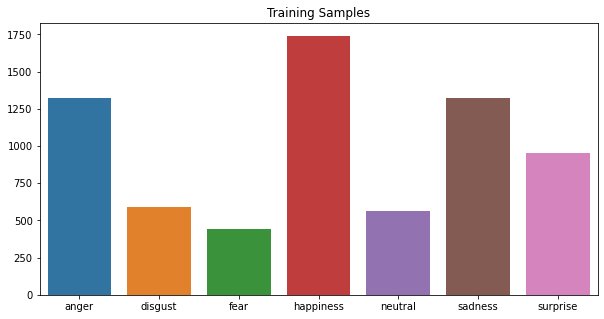

In [ ]:
#Let's plot samples distribution for training
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = train_samples[:,0], y = train_samples[:,1])
ax.set_title("Training Samples")

Text(0.5, 1.0, 'Validation Samples')

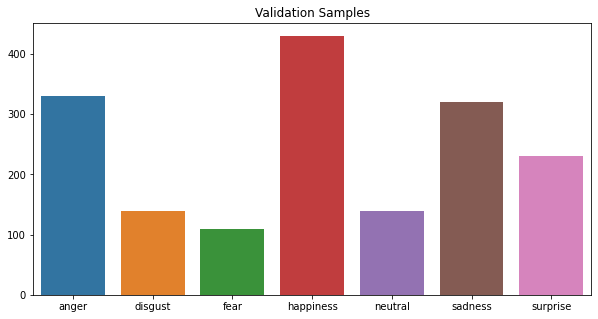

In [ ]:
#Let's plot samples distribution for testing
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = valid_samples[:,0], y = valid_samples[:,1])
ax.set_title("Validation Samples")

### Image samples

In [ ]:
def showGridImages(rows,cols,image_list):
  img_count = 0
  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,5))

  for i in range(rows):
      for j in range(cols):        
          if img_count < len(image_list):
              img = Image.open(image_list[img_count])
              axes[i, j].imshow(img)
              img_count+=1
              

In [ ]:
anger_list = os.listdir(DIR_DATA+'train/anger')[0:10]
disgust_list = os.listdir(DIR_DATA+'train/disgust')[0:10]
fear_list = os.listdir(DIR_DATA+'train/fear')[0:10]
happiness_list = os.listdir(DIR_DATA+'train/happiness')[0:10]
neutral_list = os.listdir(DIR_DATA+'train/neutral')[0:10]
sadness_list = os.listdir(DIR_DATA+'train/sadness')[0:10]
surprise_list = os.listdir(DIR_DATA+'train/surprise')[0:10]

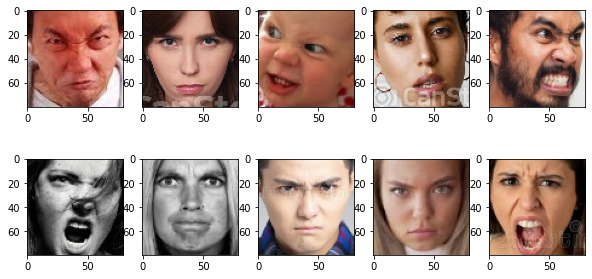

In [ ]:
#ANGER SAMPLES
image_list = []
for value in anger_list:
  image_list.append(DIR_DATA+'train/anger/'+value)

showGridImages(2,5,image_list)

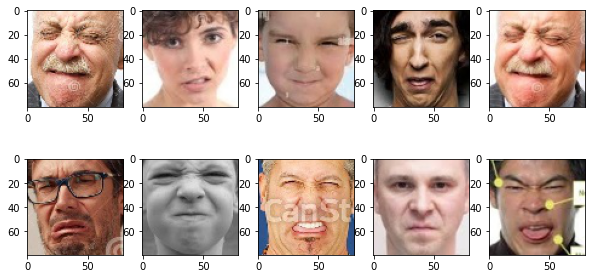

In [ ]:
#DISGUST SAMPLES
image_list = []
for value in disgust_list:
  image_list.append(DIR_DATA+'train/disgust/'+value)

showGridImages(2,5,image_list)

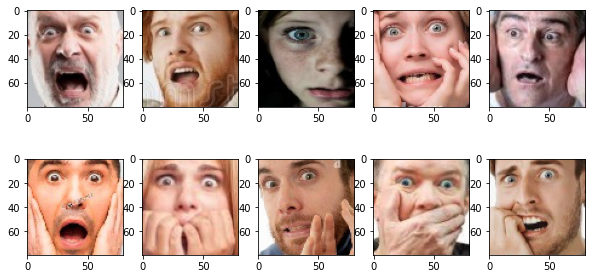

In [ ]:
#FEAR SAMPLES
image_list = []
for value in fear_list:
  image_list.append(DIR_DATA+'train/fear/'+value)

showGridImages(2,5,image_list)

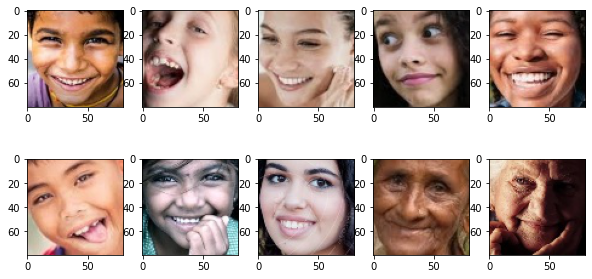

In [ ]:
#HAPPINESS SAMPLES
image_list = []
for value in happiness_list:
  image_list.append(DIR_DATA+'train/happiness/'+value)

showGridImages(2,5,image_list)

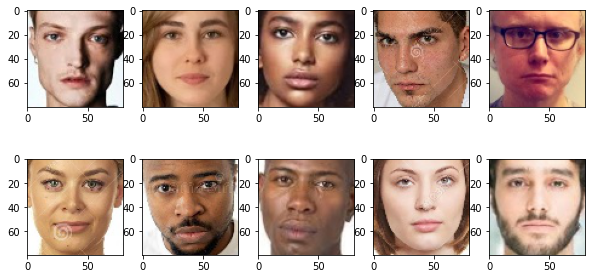

In [ ]:
#NEUTRAL SAMPLES
image_list = []
for value in neutral_list:
  image_list.append(DIR_DATA+'train/neutral/'+value)

showGridImages(2,5,image_list)

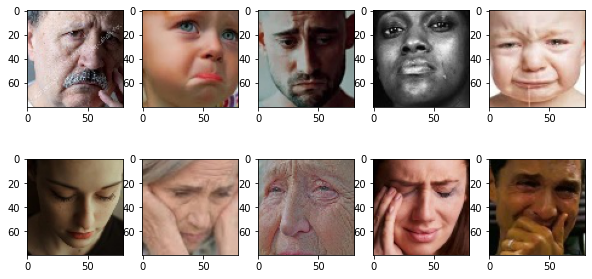

In [ ]:
#SADNESS SAMPLES
image_list = []
for value in sadness_list:
  image_list.append(DIR_DATA+'train/sadness/'+value)

showGridImages(2,5,image_list)

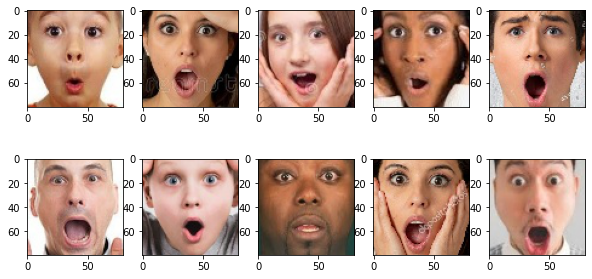

In [ ]:
#SURPRISE SAMPLES
image_list = []
for value in surprise_list:
  image_list.append(DIR_DATA+'train/surprise/'+value)

showGridImages(2,5,image_list)

## Data Preparation

We have to apply some transformations to training and test subsets, and then load the transformed data with DataLoaders. Here are the transformations we applied:
Random rotation
Random horizontal flip
Resizing to 64x64 — required for pre-trained architectures
Conversion to Tensor
Normalization

In [ ]:
IMAGE_SIZE = 64 #@param
BATCH_SIZE =  32 #@param

train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),    
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
valid_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),    
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

Now we load the data with DataLoaders.

In [ ]:
train_data = datasets.ImageFolder(os.path.join(DIR_DATA, 'train'), transform=train_transforms)
valid_data = datasets.ImageFolder(os.path.join(DIR_DATA, 'test'), transform=valid_transforms)

#torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_data.classes
class_names

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

In [ ]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 6938
    Root location: Micro_Expressions/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

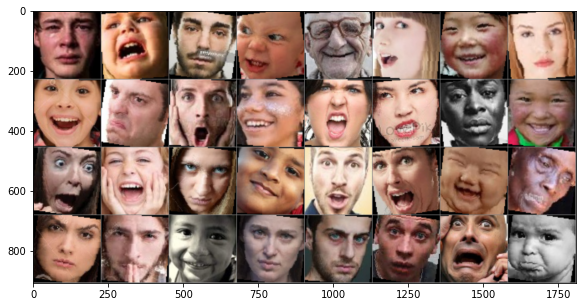

sadness, sadness, sadness, anger, happiness, surprise, happiness, neutral, surprise, anger, surprise, happiness, anger, anger, sadness, happiness,  fear, happiness, anger, happiness, surprise,  fear, happiness, sadness, anger, neutral, happiness, sadness, sadness,  fear,  fear, sadness,


In [ ]:
def imshow(img):
  #img = img/2
  npimg = img.numpy().transpose((1, 2, 0))

  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])

  npimg = std*npimg+mean
  npimg = np.clip(npimg,0,1)
  plt.imshow(npimg)
  plt.show()

#get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

#showimages
plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))

#print labels
print (' '.join('%5s,' % class_names[labels[j]] for j in range (labels.size(0))))

## Model Preparation

In [ ]:
!pip install torchviz
from torchviz import make_dot

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=ce2c3e4199d4df1d678b3db9157829da5b26c0fd205b542187a6c0465c86f51e
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


### Custom Model

In [ ]:
class CustomModel(nn.Module):
  def __init__(self):
    super(CustomModel, self).__init__()
     
    #CNN - Convolutional Layers - Block1
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1)
    
    #fully connected layers
    self.fc1 = nn.Linear(256*16*16,1024)
    self.fc2 = nn.Linear(1024,7)

    #maxpool layer
    self.pool = nn.MaxPool2d(2,2)

    #dropout layer
    self.dropout = nn.Dropout(0.2)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(-1, 256*16*16)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

custom_model = CustomModel()
custom_model.to(device)
print(custom_model)

criterion_custom = torch.nn.CrossEntropyLoss()
optimizer_custom = optim.SGD(custom_model.parameters(), lr=0.001, momentum=0.9)

CustomModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Resnet18

In [ ]:
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features

for param in model_resnet18.parameters():
    param.requires_grad = True

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_resnet18.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(0.2),
                                  nn.Linear(256, 7))

rn18_based = model_resnet18.to(device)
print(rn18_based)

criterion_rn18 = torch.nn.CrossEntropyLoss()
optimizer_rn18 = optim.SGD(rn18_based.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### VGG19

In [ ]:
vgg_based = torchvision.models.vgg19(pretrained=True)

## freeze the layers
for param in vgg_based.parameters():
    param.requires_grad = False

# Modify the last layer
number_features = vgg_based.classifier[6].in_features # 4096
#layers = list(vgg_based.classifier.children())[:-1] # Remove last layer
#layers.extend([torch.nn.Linear(number_features, 7)])
#vgg_based.classifier = torch.nn.Sequential(*layers)

vgg_based.classifier = nn.Sequential(nn.Linear(25088, 256),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(0.2),
                                  nn.Linear(256, 7))

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion_vgg = torch.nn.CrossEntropyLoss()
optimizer_vgg = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Resnet50

In [ ]:
rn50_based = torchvision.models.resnet50(pretrained=True)

## freeze the layers
for param in rn50_based.parameters():
    param.requires_grad = False

# Modify the last layer
rn50_based.fc = nn.Sequential(
               nn.Linear(2048, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(256, 7))

rn50_based = rn50_based.to(device)

print(rn50_based)

criterion_rn50 = nn.CrossEntropyLoss()
optimizer_rn50 = optim.Adam(rn50_based.fc.parameters(),lr=0.001)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Training process

In [ ]:
def train_model(model, criterion, optimizer, lr_decay, num_epochs = 25):
  """
  Function to train model
  input:
    - model 
    - criterion: CrossEntropy, R
    - optimizer: Adam, SGRD
    - lr_decay: learning rate reduction, every 25 epocs lr is reduced by lr_decay
    - num_epochs: epochs number
  output:
    - model: trained model
    - train_loss: loss array values train
    - train_accu: accuracy array values train
    - valid_accu: accuracy array values valid 

  """
  start = time.time()

  model.train()

  train_loss = []
  train_accu = []

  valid_loss = []
  valid_accu = []

  for epoch in range(num_epochs): #loop over the datset multiple times
    
    running_loss = 0.0
    correct=0
    total=0

    for data in train_loader:
      #get the inputs, data is a list of [inputs, labels]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device) #tanto modelo como los datasets tiene que estar en device

      #zero the parameter gradients
      optimizer.zero_grad()

      #forward + backward + optimize
      outputs =model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()

      optimizer.step()     

      #loss is returned as average over the batch_size: undo average
      running_loss += loss.item()*inputs.size(0)

      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
    
    loss = running_loss/len(train_loader) #average over number of batches
    accu=100.*correct/total

    train_loss.append(loss)
    train_accu.append(accu)
                
    lr_decay.step()

    print('epoch [%d/%d] train loss: %.3f, train accuracy: %.3f' % (epoch + 1, num_epochs, loss, accu))    
    print('LR:',lr_decay.get_last_lr())

  stop = time.time()
  print('Finished Training')
  print(f"Training time: {(stop - start)/60}mins")
  return model, train_loss, train_accu

### Training Custom Model

In [ ]:
# Decay LR by a factor of 0.1 every N epochs

num_epochs =  100#@param
step_size =  45#@param 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_custom, step_size=step_size, gamma=0.1)

model_custom, train_loss_custom, train_accu_custom = train_model(custom_model, 
                                               criterion = criterion_custom, 
                                               optimizer = optimizer_custom, 
                                               lr_decay = exp_lr_scheduler, 
                                               num_epochs = num_epochs)

epoch [1/100] train loss: 59.544, train accuracy: 24.229
LR: [0.001]
epoch [2/100] train loss: 52.884, train accuracy: 38.844
LR: [0.001]
epoch [3/100] train loss: 48.940, train accuracy: 44.422
LR: [0.001]
epoch [4/100] train loss: 46.924, train accuracy: 48.227
LR: [0.001]
epoch [5/100] train loss: 45.800, train accuracy: 49.438
LR: [0.001]
epoch [6/100] train loss: 44.784, train accuracy: 50.894
LR: [0.001]
epoch [7/100] train loss: 43.182, train accuracy: 52.940
LR: [0.001]
epoch [8/100] train loss: 41.045, train accuracy: 53.877
LR: [0.001]
epoch [9/100] train loss: 39.617, train accuracy: 55.001
LR: [0.001]
epoch [10/100] train loss: 38.310, train accuracy: 56.659
LR: [0.001]
epoch [11/100] train loss: 36.868, train accuracy: 57.711
LR: [0.001]
epoch [12/100] train loss: 35.640, train accuracy: 59.484
LR: [0.001]
epoch [13/100] train loss: 34.443, train accuracy: 61.199
LR: [0.001]
epoch [14/100] train loss: 33.603, train accuracy: 61.415
LR: [0.001]
epoch [15/100] train loss: 32

### Training Resnet18

In [ ]:
# Decay LR by a factor of 0.1 every N epochs

num_epochs =  100#@param
step_size =  45#@param 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_rn18, step_size=step_size, gamma=0.1)

model_rn18, train_loss_rn18, train_accu_rn18 = train_model(rn18_based, 
                                               criterion = criterion_rn18, 
                                               optimizer = optimizer_rn18, 
                                               lr_decay = exp_lr_scheduler, 
                                               num_epochs = num_epochs)

epoch [1/100] train loss: 47.394, train accuracy: 43.961
LR: [0.001]
epoch [2/100] train loss: 31.921, train accuracy: 63.635
LR: [0.001]
epoch [3/100] train loss: 25.724, train accuracy: 71.490
LR: [0.001]
epoch [4/100] train loss: 21.279, train accuracy: 76.607
LR: [0.001]
epoch [5/100] train loss: 18.913, train accuracy: 79.086
LR: [0.001]
epoch [6/100] train loss: 16.246, train accuracy: 82.070
LR: [0.001]
epoch [7/100] train loss: 14.082, train accuracy: 84.909
LR: [0.001]
epoch [8/100] train loss: 11.937, train accuracy: 87.359
LR: [0.001]
epoch [9/100] train loss: 11.144, train accuracy: 88.167
LR: [0.001]
epoch [10/100] train loss: 9.743, train accuracy: 89.161
LR: [0.001]
epoch [11/100] train loss: 8.689, train accuracy: 90.357
LR: [0.001]
epoch [12/100] train loss: 8.240, train accuracy: 91.107
LR: [0.001]
epoch [13/100] train loss: 7.124, train accuracy: 92.937
LR: [0.001]
epoch [14/100] train loss: 6.779, train accuracy: 92.937
LR: [0.001]
epoch [15/100] train loss: 5.782, 

### Training VGG19

In [ ]:
# Decay LR by a factor of 0.1 every N epochs

num_epochs =  100#@param
step_size =  45#@param 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg, step_size=step_size, gamma=0.1)

model_vgg19, train_loss_vgg19, train_accu_vgg19 = train_model(vgg_based, 
                                               criterion = criterion_vgg, 
                                               optimizer = optimizer_vgg, 
                                               lr_decay = exp_lr_scheduler, 
                                               num_epochs = num_epochs)

epoch [1/100] train loss: 50.178, train accuracy: 39.363
LR: [0.001]
epoch [2/100] train loss: 45.537, train accuracy: 45.402
LR: [0.001]
epoch [3/100] train loss: 44.179, train accuracy: 47.651
LR: [0.001]
epoch [4/100] train loss: 42.234, train accuracy: 50.159
LR: [0.001]
epoch [5/100] train loss: 41.990, train accuracy: 49.697
LR: [0.001]
epoch [6/100] train loss: 42.064, train accuracy: 50.072
LR: [0.001]
epoch [7/100] train loss: 41.053, train accuracy: 51.614
LR: [0.001]
epoch [8/100] train loss: 40.327, train accuracy: 52.393
LR: [0.001]
epoch [9/100] train loss: 39.626, train accuracy: 52.998
LR: [0.001]
epoch [10/100] train loss: 39.213, train accuracy: 53.834
LR: [0.001]
epoch [11/100] train loss: 39.020, train accuracy: 54.122
LR: [0.001]
epoch [12/100] train loss: 38.593, train accuracy: 54.785
LR: [0.001]
epoch [13/100] train loss: 38.280, train accuracy: 54.987
LR: [0.001]
epoch [14/100] train loss: 37.665, train accuracy: 55.751
LR: [0.001]
epoch [15/100] train loss: 37

### Training Resnet50


In [ ]:
# Decay LR by a factor of 0.1 every N epochs

num_epochs =  100#@param
step_size =  45#@param 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_rn50, step_size=step_size, gamma=0.1)

model_rn50, train_loss_rn50, train_accu_rn50 = train_model(rn50_based, 
                                               criterion = criterion_rn50, 
                                               optimizer = optimizer_rn50, 
                                               lr_decay = exp_lr_scheduler, 
                                               num_epochs = num_epochs)

epoch [1/100] train loss: 48.572, train accuracy: 42.606
LR: [0.001]
epoch [2/100] train loss: 41.884, train accuracy: 50.533
LR: [0.001]
epoch [3/100] train loss: 40.405, train accuracy: 53.027
LR: [0.001]
epoch [4/100] train loss: 38.763, train accuracy: 54.944
LR: [0.001]
epoch [5/100] train loss: 38.521, train accuracy: 55.001
LR: [0.001]
epoch [6/100] train loss: 37.352, train accuracy: 56.198
LR: [0.001]
epoch [7/100] train loss: 37.229, train accuracy: 56.645
LR: [0.001]
epoch [8/100] train loss: 36.582, train accuracy: 56.702
LR: [0.001]
epoch [9/100] train loss: 35.994, train accuracy: 58.273
LR: [0.001]
epoch [10/100] train loss: 36.023, train accuracy: 58.216
LR: [0.001]
epoch [11/100] train loss: 35.606, train accuracy: 58.662
LR: [0.001]
epoch [12/100] train loss: 35.566, train accuracy: 58.835
LR: [0.001]
epoch [13/100] train loss: 34.989, train accuracy: 59.383
LR: [0.001]
epoch [14/100] train loss: 35.507, train accuracy: 58.720
LR: [0.001]
epoch [15/100] train loss: 34

## Plotting metrics

In [ ]:
#Combining all loss and accuracy for training

custom = {'loss': train_loss_custom,
        'accuracy': train_accu_custom,
        'model': 'Custom Model'}

rn18 = {'loss': train_loss_rn18,
        'accuracy': train_accu_rn18,
        'model': 'resnet18'}
vgg19 = {'loss': train_loss_vgg19,
         'accuracy': train_accu_vgg19,
        'model': 'vgg19'}        
rn50 = {'loss': train_loss_rn50,
        'accuracy': train_accu_rn50,
        'model': 'resnet50'}        

df_custom = pd.DataFrame(custom)
df_rn18 = pd.DataFrame(rn18)
df_vgg19 = pd.DataFrame(vgg19)
df_rn50 = pd.DataFrame(rn50)

df_all_metrics = pd.concat([df_custom,df_rn18,df_vgg19,df_rn50]).reset_index()
df_all_metrics.columns = ['epochs', 'loss', 'accuracy', 'model']
df_all_metrics['epochs'] = df_all_metrics['epochs']+1
df_all_metrics.head()

,epochs,loss,accuracy,model
0,1,59.543788,24.228884,Custom Model
1,2,52.883911,38.844047,Custom Model
2,3,48.939562,44.422024,Custom Model
3,4,46.923723,48.227155,Custom Model
4,5,45.800231,49.437878,Custom Model


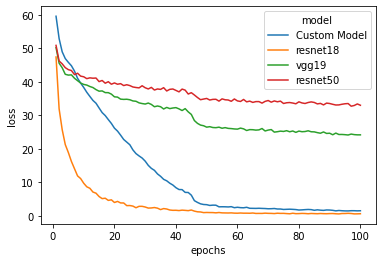

In [ ]:
sns.lineplot(data = df_all_metrics, x = df_all_metrics['epochs'], y = df_all_metrics['loss'], hue = 'model')

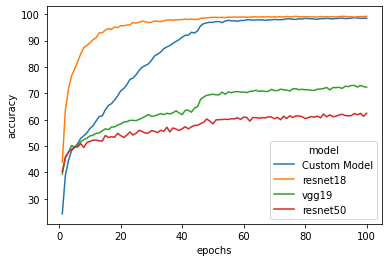

In [ ]:
sns.lineplot(data = df_all_metrics, x = df_all_metrics['epochs'], y = df_all_metrics['accuracy'], hue = 'model')

### Validation

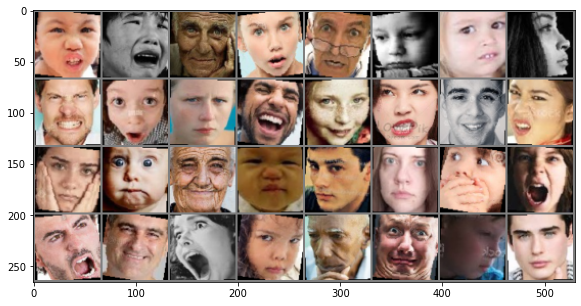

GroundTruth:  anger, sadness, happiness, surprise, surprise, sadness, disgust, sadness, anger, surprise, neutral, happiness, happiness, anger, happiness, anger, sadness,  fear, happiness, disgust, neutral, neutral,  fear, anger, anger, happiness,  fear, anger, sadness,  fear, sadness, neutral,


In [ ]:
images, labels = dataiter.next()
 
#print images
plt.figure(figsize=(15,5))
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join ('%5s,'%tuple(class_names)[labels[j]] for j in range(labels.size(0))))

In [ ]:
truth = "".join ('%5s,'%tuple(class_names)[labels[j]] for j in range(labels.size(0))).split(',')

Predictions

In [ ]:
images, labels = images.to(device), labels.to(device)

In [ ]:
outputs = custom_model(images)
_, predicted = torch.max(outputs,1) #max = la mayor probabilidad de los las etiquetas predichas.
print('Predicted: ',' '.join('%5s,'%tuple(class_names)[predicted[j]] for j in range(predicted.size(0))))
cstm = "".join ('%5s,'%tuple(class_names)[labels[j]] for j in range(labels.size(0))).split(',')

Predicted:  anger, sadness, happiness, surprise, surprise, sadness, disgust, sadness, anger, surprise, neutral, happiness, happiness, anger, happiness, anger, sadness,  fear, happiness, disgust, neutral, neutral,  fear, anger, anger, happiness,  fear, anger, sadness,  fear, sadness, neutral,


In [ ]:
outputs = model_rn18(images)
_, predicted = torch.max(outputs,1) #max = la mayor probabilidad de los las etiquetas predichas.
print('Predicted: ',' '.join('%5s,'%tuple(class_names)[predicted[j]] for j in range(predicted.size(0))))
rn18 = "".join ('%5s,'%tuple(class_names)[labels[j]] for j in range(labels.size(0))).split(',')

Predicted:  anger, sadness, happiness, surprise, surprise, sadness, disgust, sadness, anger, surprise, neutral, happiness, happiness, anger, happiness, anger, sadness,  fear, happiness, disgust, neutral, neutral,  fear, anger, anger, happiness,  fear, anger, sadness,  fear, sadness, neutral,


In [ ]:
outputs = model_vgg19(images)
_, predicted = torch.max(outputs,1) #max = la mayor probabilidad de los las etiquetas predichas.
print('Predicted: ',' '.join('%5s,'%tuple(class_names)[predicted[j]] for j in range(predicted.size(0))))
vgg19 = "".join ('%5s,'%tuple(class_names)[labels[j]] for j in range(labels.size(0))).split(',')

Predicted:  anger, sadness, happiness, surprise, surprise, sadness, happiness, sadness, anger, surprise, anger, happiness, anger, anger, neutral, anger, sadness,  fear, happiness, sadness, anger, neutral,  fear, anger, anger, neutral,  fear, anger, sadness, happiness, anger, neutral,


In [ ]:
outputs = model_rn50(images)
_, predicted = torch.max(outputs,1) #max = la mayor probabilidad de los las etiquetas predichas.
print('Predicted: ',' '.join('%5s,'%tuple(class_names)[predicted[j]] for j in range(predicted.size(0))))
rn50 = 'Predicted: ',' '.join('%5s,'%tuple(class_names)[predicted[j]] for j in range(predicted.size(0))).split(',')


Predicted:  disgust, sadness, happiness, anger, happiness, sadness, sadness, sadness, anger, surprise, sadness, happiness, anger, anger, sadness, anger, sadness, surprise, happiness, anger, anger, anger, surprise, surprise, anger, happiness, sadness, anger, sadness,  fear, sadness, neutral,


In [ ]:
data_predict = {
    'truth': truth,
    'cstm': cstm,
    'resnet18': rn18,
    'vgg19': vgg19,
    'resnet50': rn50
}


### Validation Evaluation

Overall Model Validation Accuracy

In [ ]:
model_custom.eval()
correct = 0
total = 0
with torch.no_grad(): # evita gradientes de validación ya que no existe backward
  for data in valid_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = custom_model(images)
    _, predicted = torch.max(outputs,1)
    total += labels.size(0)
    correct +=  (predicted==labels).sum().item()
print('Accuracy of the network on valid images: %d %%' %(100*correct/total))
accuracy_custom = correct/total

Accuracy of the network on test images: 77 %


In [ ]:
model_rn18.eval()
correct = 0
total = 0
with torch.no_grad(): # evita gradientes de validación ya que no existe backward
  for data in valid_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model_rn18(images)
    _, predicted = torch.max(outputs,1)
    total += labels.size(0)
    correct +=  (predicted==labels).sum().item()
print('Accuracy of the network on valid images: %d %%' %(100*correct/total))
accuracy_rn18 = correct/total

Accuracy of the network on test images: 82 %


In [ ]:
model_vgg19.eval()
correct = 0
total = 0
with torch.no_grad(): # evita gradientes de validación ya que no existe backward
  for data in valid_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model_vgg19(images)
    _, predicted = torch.max(outputs,1)
    total += labels.size(0)
    correct +=  (predicted==labels).sum().item()
print('Accuracy of the network on valid images: %d %%' %(100*correct/total))
accuracy_vgg19 = correct/total

Accuracy of the network on test images: 62 %


In [ ]:
model_rn50.eval()
correct = 0
total = 0
with torch.no_grad(): # evita gradientes de validación ya que no existe backward
  for data in valid_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model_rn50(images)
    _, predicted = torch.max(outputs,1)
    total += labels.size(0)
    correct +=  (predicted==labels).sum().item()
print('Accuracy of the network on test images: %d %%' %(100*correct/total))
accuracy_rn50 = correct/total

Accuracy of the network on test images: 59 %


Text(0, 0.5, 'Validation Accuracy')

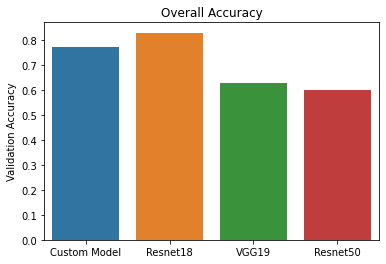

In [ ]:
list_val_accuracy = [accuracy_custom,accuracy_rn18,accuracy_vgg19,accuracy_rn50]
ax = sns.barplot(y = list_val_accuracy, x = ['Custom Model', 'Resnet18','VGG19','Resnet50'])
ax.set_title('Overall Accuracy')
ax.set_ylabel('Validation Accuracy')

Model Validation Accuracy by class

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in valid_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model_rn18(images)
    _, predicted = torch.max(outputs,1)
    c = (predicted == labels).squeeze()
    for i in range(labels.size(0)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label]+=1

for i in range(7):
  print('Accuracy of %5s: %2d %%'% (tuple(class_names)[i], 100*class_correct[i]/class_total[i]))

Accuracy of anger: 82 %
Accuracy of disgust: 73 %
Accuracy of  fear: 64 %
Accuracy of happiness: 94 %
Accuracy of neutral: 74 %
Accuracy of sadness: 81 %
Accuracy of surprise: 83 %


## Model selection for Face Detection

In [ ]:
model_ft = model_rn18

## Face Detection with MTCNN

In [ ]:
!pip install facenet_pytorch 

     |████████████████████████████████| 1.9 MB 15.8 MB/s 


In [ ]:
from facenet_pytorch import MTCNN

from PIL import Image, ImageDraw, ImageFont

emotion_color_dict = {
    'anger': (225,33,33),
    'disgust': (64,55,128),
    'fear': (132,83,84),
    'happiness': (24,31,49),
    'neutral': (24,131,49),
    'sadness': (124,231,49),
    'surprise': (24,31,149)
  }

fnt = ImageFont.truetype('BebasNeue-Regular.ttf', 15)

def predict_emotion(img):
  """Predicting emotions"""
  mtcnn = MTCNN(keep_all=True)
  all_boxes = mtcnn.detect(img)

  # Check if MTCNN detect good faces
  good_boxes = []
  for index, proba in enumerate(all_boxes[1]):
    if(proba > 0.9):
      good_boxes.append(all_boxes[0][index])

  model_ft.eval()
  for boxes in good_boxes:
    img_cropped = img.crop(boxes)

    transform = transforms.Compose([transforms.Resize((64,64),
                                                      interpolation=Image.NEAREST),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    img_tensor = transform(img_cropped)
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
      output = F.softmax(model_ft(img_tensor.view(-1, 3, 64, 64))).squeeze()
    
    prob_emotion = output[torch.argmax(output).item()].item()
    pred_emotion = class_names[torch.argmax(output)]

    emotion_color = emotion_color_dict[pred_emotion]

    left, top, right, bottom = boxes
    x, y = left+5, bottom+2.5

    emotion_text = f'{pred_emotion} {round(prob_emotion, 2)}'

    w, h = fnt.getsize(emotion_text)

    draw = ImageDraw.Draw(img)
    draw.rectangle(boxes, outline=emotion_color)
    draw.rectangle((x-5,y-2.5,x+w+5,y+h+2.5), fill=emotion_color)
    draw.text((x,y), emotion_text, font=fnt, fill=(255,255,255))

Testing with images for face detection and emotions

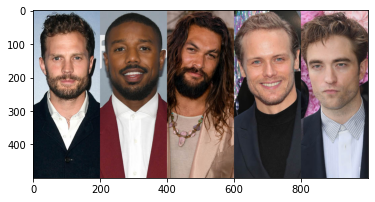

In [ ]:
img_path = 'images5.jpeg'
img = Image.open(img_path).convert('RGB')
plt.imshow(img)

In [ ]:
predict_emotion(img)
result_img_name = 'prediction5.jpg'
img.save(result_img_name)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Saving Model

In [ ]:
torch.save(model_ft.state_dict(),'FE_transfer.pth')